# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import time
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 1. Data

In [2]:
cn7 = pd.read_csv("../data/processed/labeled_data_cn7.csv", parse_dates=True)

In [3]:
cn7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3974 entries, 0 to 3973
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TimeStamp                 3974 non-null   object 
 1   Hopper_Temperature        3974 non-null   float64
 2   Mold_Temperature_4        3974 non-null   float64
 3   Average_Back_Pressure     3974 non-null   float64
 4   Max_Screw_RPM             3974 non-null   float64
 5   Barrel_Temperature_1      3974 non-null   float64
 6   Reason                    3974 non-null   object 
 7   Max_Injection_Pressure    3974 non-null   float64
 8   Max_Injection_Speed       3974 non-null   float64
 9   Barrel_Temperature_2      3974 non-null   float64
 10  Barrel_Temperature_5      3974 non-null   float64
 11  Mold_Temperature_3        3974 non-null   float64
 12  Average_Screw_RPM         3974 non-null   float64
 13  Max_Switch_Over_Pressure  3974 non-null   float64
 14  Cushion_

# 2. 학습/평가 데이터 분리를 위한 데이터 전처리

In [4]:
numerical_features = [x for x in cn7.columns if np.dtype(cn7[x]) == "float64"]

In [5]:
cn7["PassOrFail"].value_counts()

0    3946
1      28
Name: PassOrFail, dtype: int64

In [6]:
# 양품
cn7_Y = cn7[cn7["PassOrFail"] == 0]
print("CN7의 양품 개수:", len(cn7_Y))

CN7의 양품 개수: 3946


In [7]:
# 불량
cn7_N = cn7[cn7["PassOrFail"] == 1]
print("CN7의 불량 개수:", len(cn7_N))

CN7의 불량 개수: 28


**잡음 제거 오토인코더 모델에 학습시킬 데이터의 형태는 클래스 변수가 없어야 하므로 변수 "PassOrFail"을 제거함

In [8]:
# Data for passed parts
cn7_Y = cn7_Y[numerical_features]
# Data for Failed parts
cn7_N = cn7_N[numerical_features]

#### 학습/평가 데이터 분리 (6:4 비율)

In [9]:
cn7_Y.shape

(3946, 23)

In [10]:
cn7_train_Y, cn7_test_Y = train_test_split(cn7_Y, test_size=0.1)

# 평가 데이터 (불량)
cn7_test_N = cn7_N

print(f"CN7 학습 데이터 (양품) 개수: {len(cn7_train_Y)}")
print(f"CN7 평가 데이터 (양품) 개수: {len(cn7_test_Y)}")
print(f"CN7 평가 데이터 (불량) 개수: {len(cn7_test_N)}")

CN7 학습 데이터 (양품) 개수: 3551
CN7 평가 데이터 (양품) 개수: 395
CN7 평가 데이터 (불량) 개수: 28


In [11]:
scaler = StandardScaler()

cn7_train_Y = scaler.fit_transform(cn7_train_Y)
cn7_test_Y = scaler.transform(cn7_test_Y)
cn7_test_N = scaler.transform(cn7_test_N)

# 3. Mahalanobis Distance

In [12]:
def mahalanobis(x=None, data=None, cov=None):
    """
    Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data, axis=0)
    if not cov:
        cov = np.cov(data.T)
        # cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()  # Can't understand why .diagonal() is used

In [13]:
class MahalanobisOneclassClassifier():
    def __init__(self, xtrain, significance_level=0.01):
        self.xtrain = xtrain
        self.critical_value = chi2.ppf((1-significance_level), df=xtrain.shape[1] - 1) # df = degree of freedom
        print('Critical value is: ', self.critical_value)

    def predict_proba(self, xtest):
        mahalanobis_dist = mahalanobis(xtest, self.xtrain)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, xtest):
        return np.array([int(i) for i in self.predict_proba(xtest) > self.critical_value])

# 4. 임계값 정의

In [14]:
clf = MahalanobisOneclassClassifier(cn7_train_Y, significance_level=0.1)

Critical value is:  30.813282343953027


In [15]:
threshold = clf.critical_value

# 5. 데이터 각각의 예측값과 복원 오차 확인

## 5.1. 평가 데이터 (양품) 대상 모델 성능 검증 

In [16]:
# 예측값
cn7_MD_Y = clf.predict_proba(cn7_test_Y)

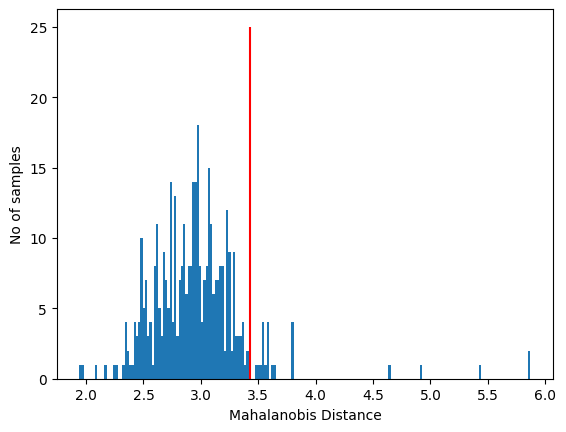

In [17]:
# 시각화

plt.hist(np.log(cn7_MD_Y), bins=200)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(np.log(threshold), 0, 25, color="red")
plt.show();

In [18]:
# 불량으로 판단한 데이터 확인

cn7_test_Y_anomalies = cn7_MD_Y > threshold
print("불량 개수: ", np.sum(cn7_test_Y_anomalies))
print("정확도: ", (cn7_test_Y.shape[0]-np.sum(cn7_test_Y_anomalies))/cn7_test_Y.shape[0])

불량 개수:  24
정확도:  0.9392405063291139


## 5.2. 평가 데이터 (불량) 대상 모델 성능 검증 

In [19]:
# 예측값
cn7_MD_N = clf.predict_proba(cn7_test_N)

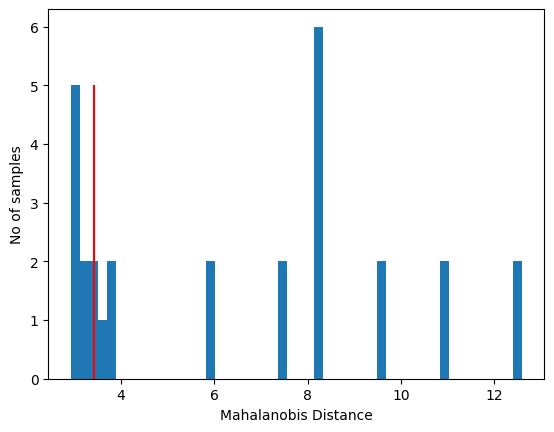

In [20]:
# 시각화

plt.hist(np.log(cn7_MD_N), bins=50)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(np.log(threshold), 0, 5, color="red")
plt.show();

In [21]:
# 불량으로 판단한 데이터 확인

cn7_test_N_anomalies = cn7_MD_N > threshold
print("불량 개수: ", np.sum(cn7_test_N_anomalies))
print("정확도: ", np.sum(cn7_test_N_anomalies)/cn7_test_N.shape[0])

불량 개수:  20
정확도:  0.7142857142857143


# 6. 결과 분석

In [22]:
# 평가 데이터의 실제값

cn7_true = np.concatenate(
    [np.zeros(len(cn7_test_Y_anomalies)), np.ones(len(cn7_test_N_anomalies))]
)

In [23]:
# 평가 데이터의 예측값

cn7_prediction = np.concatenate(
    [cn7_test_Y_anomalies, cn7_test_N_anomalies]
)

In [24]:
confusion_matrix(cn7_true, cn7_prediction)

array([[371,  24],
       [  8,  20]], dtype=int64)

In [25]:
print(classification_report(cn7_true, cn7_prediction))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       395
         1.0       0.45      0.71      0.56        28

    accuracy                           0.92       423
   macro avg       0.72      0.83      0.76       423
weighted avg       0.94      0.92      0.93       423

